<a href="https://colab.research.google.com/github/b-hill/cop4630/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 3

### Imports

In [0]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

## Problem 1

### Function: get_random_data

This function generates random data. 

Config: 
*   2 features -> shape `(m,2)`
*   Binary classification -> shape `(m,1)`
*   Populates around a line `w * x + b`
*   Direction (up or down) from line determined by class label `c`. 
*   Distance from line determined by `n` which is number generated from normal distribution defined by `sigma` and `mu`. 
*   Classes: `c` <- 50/50 boolean
*   Feat. 1: `x_1` <- random uniform float [0,1)
*   Feat. 2: `x_2` <- `w * x_1 + b + (-1)**c * n`

Parameters:
*   User entered:
  *   `w`: Central line slope
  *   `b`: Central line intercept
  *   `mu`: Mean of normal distribution
  *   `sigma`: Standard deviation of normal distribution
  *   `m`: Number of data instances to generate

*   Generated: 
  *   `c`:  Class label, 50/50 boolean
  *   `n`:  `np.random.normal(mu, sigma, 1)`







In [0]:
def get_random_data(w, b, mu, sigma, m): 
  
  # init dfs
  labels = pd.DataFrame()
  data = pd.DataFrame()

  # fill dfs
  for i in range(0, m):

    # labels
    c = random.choice([0, 1])
    row = pd.Series([c], index=['c'])
    row_labels = pd.DataFrame([row])
    labels = pd.concat([row_labels, labels], ignore_index=True)

    # data
    x_1 = random.uniform(0,1)
    n = np.random.normal(mu, sigma, 1)
    x_2 = w * x_1 + b + (-1)**c * n
    row = pd.Series([x_1, x_2], index=['x_1', 'x_2'])
    row_data = pd.DataFrame([row])
    data = pd.concat([row_data, data], ignore_index=True)

  return [labels, data]

### Manipulate data generation

In [0]:
w = .6
b = .8
mu = .5
sigma = .2
m = 1000

`labels` contains the features for each row, `x_1` and `x_2`

`data` contains the class label for each row, `c`

In [0]:
labels, data = get_random_data(w, b, mu, sigma, m)

Sample of combined data

In [5]:
main = pd.concat([data, labels], axis=1, ignore_index=True).head()
main.columns = ['x_1', 'x_2', 'c']
main

,x_1,x_2,c
0,0.820983,[0.8182556245569345],1
1,0.270292,[1.4079437579634566],0
2,0.141365,[1.4294143258212124],0
3,0.587685,[0.516939464192246],1
4,0.599446,[1.5117317516008313],0


### Function: display_random_data

2D scatter plot of generated data. 

*   Blue dots correspond to `c=0`
*   Red dots correspond to `c=1`

In [0]:
def display_random_data(labels, data):
  main = pd.concat([data, labels], axis=1, ignore_index=True)
  main.columns = ['x_1', 'x_2', 'c']
  ax = sns.scatterplot(x="x_1", y="x_2", data=main, hue="c", palette=["Blue", "Red"])
  ax.plot()

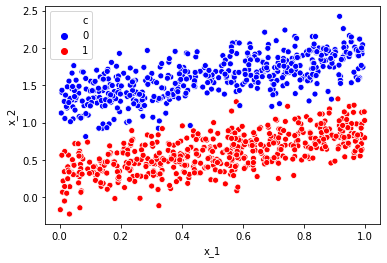

In [7]:
display_random_data(labels, data)

### Split data

80% of the data is sent to the train set which is used to fit the model. 

The other 20% of the data is sent ot the test set which is used to judge the accuracy of th model after training. 

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

Due to server side chnage where the default TF version has been updated by google, these changes are needed to prevent type error bugs.

In [0]:
# side affect of tf update from 1.4 to 2.2
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

## Problem 2

### Model construction 

This model is very simple and consits of just 1 dense layer. 
*   The `Sequential` model is a linear stack of layers.
*   The `Dense` layer has a single dimension output and takes in the 2 features of each instance.
*   The `sgd` optimizer stands for stochastic gradient descent. 
*   The `binary_crossentropy` loss function is used for classification between 2 classes, hence binary. 
*   The `accuracy` metric returns a percentage of correct predictions. 

In [0]:
model = Sequential()
model.add(Dense(1, input_shape=(2,)))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model training

*   `epochs` determines how many iterations to train the model
*   `batch_size` determines the number of samples per gradient update. 

In [11]:
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=0)

### Model Evaluation 

Gets the weights and bias the model generates. These will be used to generate the line the model uses to divide the data up into the 2 classes. The weights are avergaed out to get the slope ????? and the the bias is used as the y-intercept. 

In [12]:
weights, bias = model.layers[len(model.layers)-1].get_weights()
print(weights, bias)

[[ 1.4210924]
 [-2.3073657]] [2.2925391]


Accuracy rating of the model. 

In [13]:
loss, acc = model.evaluate(x_test, y_test)
print(loss, acc)

7/7 [==============================] - 0s 1ms/step - loss: 0.0194 - accuracy: 0.9900
0.019439609721302986 0.9900000095367432


### Function: model_accuracy

Similar to the first graph. 

*   The `blue/green` line describes the actual line used to generate the data in the first place.
*   The `orange` line describes the line the model guesses is used to generate the data. Above this line, the model would guess every point is `blue` and below this point it would guess every point is `red`. 

In [0]:
def model_accuracy(labels, data, w, b, weights, bias):
  main = pd.concat([data, labels], axis=1, ignore_index=True)
  main.columns = ['x_1', 'x_2', 'c']
  ax = sns.scatterplot(x="x_1", y="x_2", data=main, hue="c", palette=["Blue", "Red"])
  xmax =  data['x_1'].max()
  ax.plot([0, xmax], [ b, w*xmax + b], linewidth=4)
  ax.plot([0, xmax], [bias[0], np.mean(weights)*xmax + bias[0]], linewidth=4)

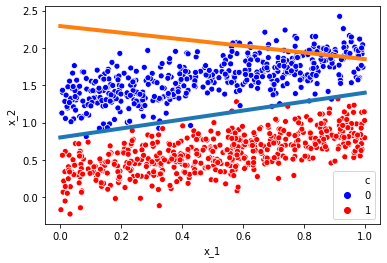

In [15]:
model_accuracy(labels, data, w, b, weights, bias)

In [0]:
### heatmap here

## Problem 3